# Representing 3D objects

## Contents

* Implicit representations
  - basics
  - signed distances
  - splines

In [1]:
%matplotlib inline

#These are the python libraries used to illustrate this course

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
import io
import math
from IPython.display import HTML
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D

## Implicit representations

### Basics

Mathematically, representing a shape consists in defining the locus of its points. This allows for a compact representation of shapes by simply providing their equation. This can be done in several ways. For instance, a sphere with center $\mathbf{c}$ and radius $r$ can be defined as

$$
\left\{ 
  \mathbf{c} + 
  r\begin{pmatrix} 
    \cos{\theta}\cos{\varphi} \\ 
    \sin{\theta}\cos{\varphi} \\ 
    \sin{\varphi} 
  \end{pmatrix},
  \theta \in \left[0, 2\pi\right],
  \varphi \in \left[-\frac{\pi}{2}, \frac{\pi}{2}\right]
 \right\}
$$

as a function of two variables. This is a parametric representation. With such a representation, it is easy to get points on the surface. Sampling $\theta$ and $\phi$ from their respective intervals yields a sampling of the sphere. Another representation for the same sphere could be

$$
\left\{ \mathbf{x} \in \mathbb{R}^3, \lVert \mathbf{x} - \mathbf{c} \rVert = r \right\}
$$

which corresponds to using an isolevel of a function. With such a representation, it becomes more difficult to get points on the object, but using the sign of the underlying function $f(\mathbf{x}) = \lVert \mathbf{x} - \mathbf{c} \rVert - r$, it becomes easy to determine whether a point in space in inside or outside the sphere. When it comes to generating an image of the shape, determining the pixels corresponding to an object. Using matplotlib here, we can try both solutions in 2D. First we sample $\theta$ in $[0, 2\pi]$. Then for each sample we generate a point on the circle.

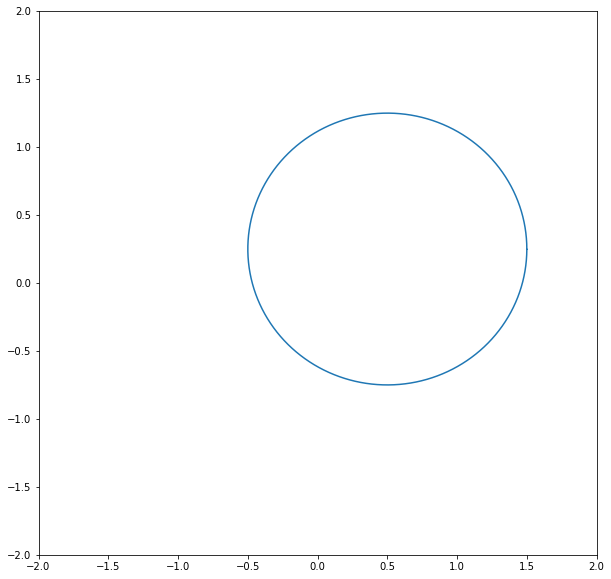

In [2]:
theta = np.arange(0, 2*math.pi, 0.01)
circle_x = 0.5 + 1*np.cos(theta)
circle_y = 0.25 + 1*np.sin(theta)

fig = plt.figure(figsize=(10,10))
fig.gca().set_xlim((-2,2))
fig.gca().set_ylim((-2,2))
plt.plot(circle_x, circle_y)
plt.show()

As a second option, we use sample $[-2, 2]^2$ and determine for each sample difference between the distance to the center and the radius. We finally plot the 0 isocontour of this function. Algorithmically, pixels will be turned on when neighboring grid samples have different signs. Between samples, the value of the function is linearly interpolated to get the locus of the isocontour.

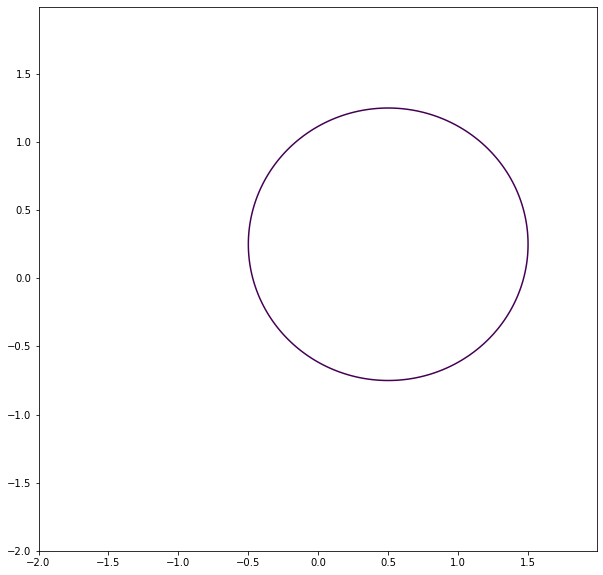

In [3]:
x,y = np.meshgrid(np.arange(-2,2,0.01), np.arange(-2,2,0.01))

def circle(cx, cy, r):
    return lambda x,y: np.sqrt((x-cx)**2 + (y-cy)**2) - r

c = circle(0.5, 0.25, 1)

fig = plt.figure(figsize=(10,10))
plt.contour(x,y,c(x,y),[0])
plt.show()

Each method has its advantages and drawbacks. Note first that the first method was easy in 2D, by approximating the curve by a sequence of segments. This becomes trickier in 3D for a surface to determine how to connect the samples. In terms of sampling, each sample in the parametric representation corresponds to a point on the circle, and it is not difficult to guess the region of space to draw from these samples. In the isolevel method, the whole 2D grid was sampled and the region had to be guessed using prior knowledge. The parametric representation however may be unevenly parameterized, and guessing the sampling resolution depending on the region in space to draw may be difficult. For general shapes, it is also often more difficult to get a global parametric representation, and piecewise parameterizations are used.

### Signed Distance Functions (SDF)

Signed distance function representations use the isolevel approach. They get a lot of success because efficient algorithms exist to combine and draw them. The basic idea is that the shape is describe by the function computing signed the distance to it. A positive value corresponds to a point outside the shape, and a negative value a point inside. The second representation presented above for the circle is a signed distance function. Many expressions exist for various shapes : sphere, ellipse, box, cylinder, cone, torus, ... A great specialist of the field is Inigo Quilez who has [wonderful turorials](https://iquilezles.org/www/articles/distfunctions/distfunctions.htm) and [demos](https://www.youtube.com/watch?v=8--5LwHRhjk) on the subject.

To define the distance function to an axis aligned box for instance, we can define the box with a center point $\mathbf{c}$ and a vector $\mathbf{w}$ between this center and one of its corners. The coordinates of this vector are half the width of the box along each axis. Given a point $\mathbf{p}$ for which we want to compute the distance, we can divide the space in 27 areas (in 3D) to determine its nearest point by elongating each face of the box as infinite planes. For each of the 26 regions outside the box, the nearest point on the box is the orthogonal projection of $\mathbf{p}$ on the piece of the box that is adjacent to the region : 8 regions adjacent to a vertex of the box, 12 regions adjacent to an edge and 6 regions adjacent to a face. Since the box is aligned with the x, y and z axis, the orthogonal projection is just a matter of getting some of the coordinates of the point. For the last region inside, the distance is the distance to the nearest face of the box.

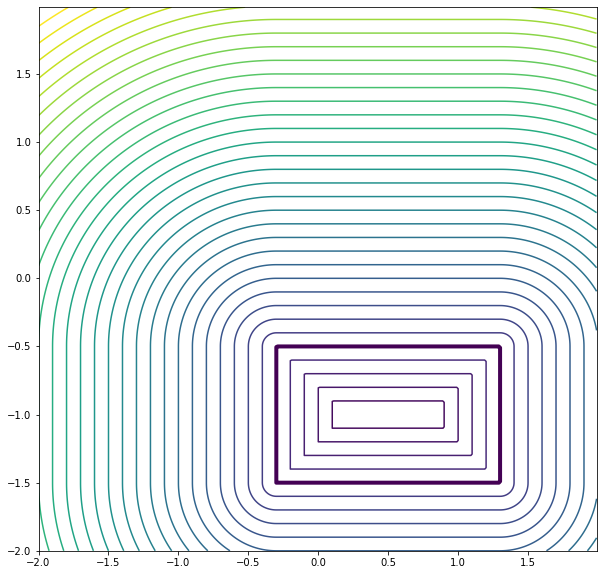

In [4]:
def box(cx, cy, wx, wy):
    def bx_distance(px, py):
        #distance to the center
        dx = np.abs(px - cx)
        dy = np.abs(py - cy)
        #distance to the box on each axis
        dwx = dx - wx
        dwy = dy - wy
        #clamped positive distance, used when p outside, 0 if inside because of the clamping
        pdwx = np.maximum(dwx, 0)
        pdwy = np.maximum(dwy, 0)
        outside_distance = np.sqrt(pdwx**2 + pdwy**2)
        #clamped negative distance, used when p inside, 0 is outside because of the clamping
        inside_distance = np.minimum(np.maximum(dwx, dwy), 0)
        return outside_distance + inside_distance
    return bx_distance

b0 = box(0.5, -1, 0.8, 0.5)

fig = plt.figure(figsize=(10,10))
plt.contour(x,y,b0(x,y), np.arange(-0.5, 3, 0.1))
plt.contour(x,y,b0(x,y), [0], linewidths = 4)
plt.show()   

Note that we get for free the distance function to a box with rounded corners and edges by simply shifting the isolevel used. Now the truly interesting part with signed distance functions is that you can perform operations to combine multiple functions. The easiest one is the union. given multiple shapes, and knowing the distance to each shape, the distance to the union of the shapes is simply the minimum of the individual distances.

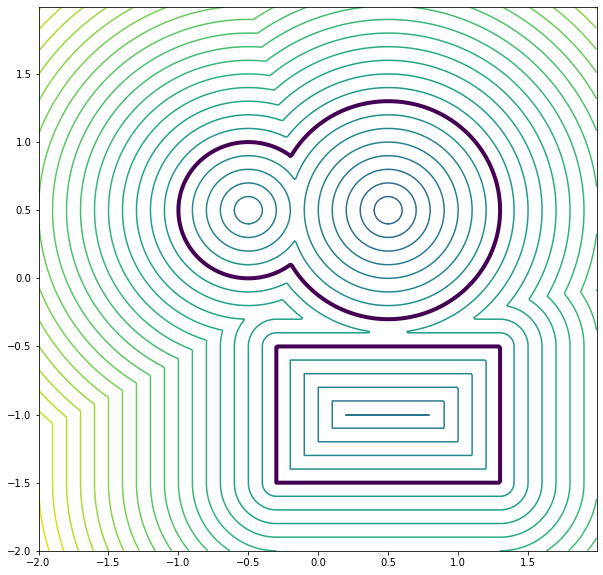

In [5]:
def union(s1, s2):
    return lambda x,y : np.minimum(s1(x,y), s2(x,y))

c0 = circle(-0.5,0.5,0.5)
c1 = circle(0.5,0.5, 0.8)

u1 = union(c0, c1)
u2 = union(u1, b0)

fig = plt.figure(figsize=(10,10))
plt.contour(x,y,u2(x,y), np.arange(-2,2, 0.1))
plt.contour(x,y,u2(x,y), [0], linewidths = 4)

plt.show()

To go further with operations on signed distance functions, we need to understand how these are rendered. When plotting these above, we sample a dense 2D grid. When rendering 3D objects with a perspective camera however, the classical approach is to ray trace the scene : each ray is issued from the eye of the observer in some direction, and the first thing hit by the ray is the visible object in that direction.

A naive approach to raytrace implicit functions is to march along the ray from the origin to try and find two successive points along the ray, one with a positive distance and one with a negative distance. From these two points, knowing that the distance function is continuous, the intermediate value theorem states that a zero of the distance lies in the interval, and it can be located more precisely using dichotomy. This approach is robust and only assumes that the function is continuous. It does not actually need to be a distance. It is however sensitive to the choice of the initial step length. If the step length is too big wrt. the size of the features of the surface, it could traverse it multiple times in a single step and miss the intersection.

For distance functions however, a more efficient algorithm exists with no risk of missing the surface. Given any point in space, knowing the distance to the surface provides an empty ball centered on the point, with the distance as a radius. This ball is tangent to the surface at some point, but contains no portion of the surface. We can therefore advance along the ray up the the point where the ray exits the ball, and iterate. This algorithm is called sphere tracing.

In [6]:
def sphere_trace(f, cx, cy, dx, dy, eps = 0.0001):
    #we assume here that the ray direction (dx, dy) is normalized
    #storage for the algorithm steps
    centers = [(cx,cy)]
    radii = []
    circles = []
    #initial point on the ray
    c = [cx, cy]
    while c[0] > -2 and c[0] <  2 and c[1] > -2 and c[1] < 2:
        #we are still in the region of interest, compute the empty ball
        r = abs(f(c[0], c[1]))
        radii.append(r)
        circles.append(matplotlib.patches.Circle((c[0], c[1]), r))
        if r < eps:
            #we are closer to the surface than the desired threshold, stop here
            break
        #we are still far from the surface, advance along the ray to the boundary of the empty ball
        c[0] += r*dx
        c[1] += r*dy
        centers.append((c[0], c[1]))
    #present the final data
    collection = matplotlib.collections.PatchCollection(circles, cmap = 'plasma', alpha=0.2, edgecolor='black')
    #collection.set_array(radii)
    collection.set_array(range(len(circles)))
    return np.array(centers), collection

def animate_sphere_trace(f, cx, cy, default_theta = 0):
    def st_update(theta = default_theta):
        #normalized direction
        dx = math.cos(theta)
        dy = math.sin(theta)
        #sphere trace
        centers, circles = sphere_trace(f, cx, cy, dx, dy)
        #plot the 0 isolevel
        fig = plt.figure(figsize=(10,10))
        plt.contour(x,y,f(x,y), [0])
        #add the set of balls
        ax = plt.gca()
        ax.set_xlim((-2,2))
        ax.set_ylim((-2,2))
        ax.add_collection(circles)
        #add the walk steps along the ray
        plt.plot(centers[:,0], centers[:,1], '-o', color='black')
        #add the hit point
        ax.add_patch(matplotlib.patches.Circle(centers[-1,:], 0.1, edgecolor = 'red', fill=False, linewidth = 2))
        #add the number of walk steps
        plt.text(-1.8,1.8, f"steps : {len(centers)}")
        plt.show()
    return st_update

In [7]:
update = animate_sphere_trace(u2, -1.5, -0.35, 0.03)
    
_=widgets.interact(update, theta = (-math.pi/2, math.pi/2, 0.01))

interactive(children=(FloatSlider(value=0.03, description='theta', max=1.5707963267948966, min=-1.570796326794…

Note however as a drawback that if the ray passes close to the surface but misses it, it can lead to many iterations (the number of which depends on how close to the surface the ray passes).

This algorithm only requires the ball defined at each step to be empty. It is therefore able to render isolevels for functions being *lower bounds* to the distance to an object : if the value of the  function is always smaller than the actual distance, the balls are empty, and we can apply the previous method. For sphere tracing to be efficient however, the bound has to be as tight as possible. This property allows for other operations. The **intersection** of two shapes can be built using the maximum of the distance to the two shapes. This is not an exact distance : if the two shapes do not intersect, the distance should be infinite where the maximum of the two distances is not. Yet, the 0 isolevel is correct, and the result is a lower bound on the distance. We can therefore apply sphere tracing.

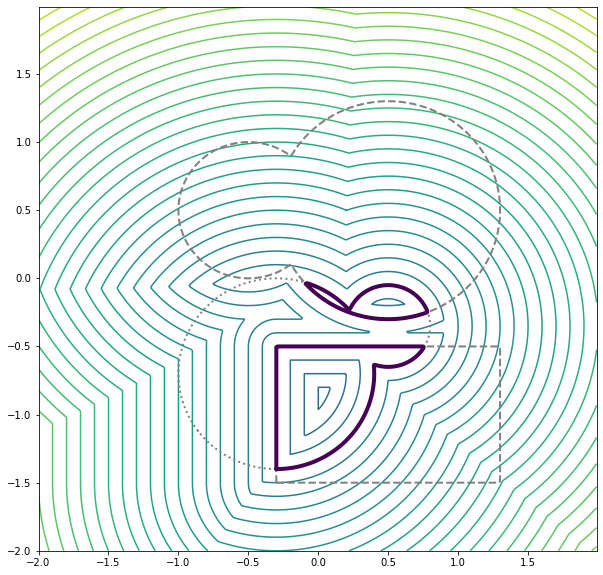

In [8]:
def intersection(s1, s2):
    return lambda x, y: np.maximum(s1(x,y), s2(x, y))

c4 = circle(0.5, -0.35, 0.3)
c5 = circle(-0.3, -0.7, 0.7)
u3 = union(c4, c5)
inter = intersection(u2, u3)

fig = plt.figure(figsize=(10,10))
plt.contour(x,y,inter(x,y), np.arange(-2,3,0.1))
plt.contour(x,y,u2(x,y), [0], colors = 'gray', linestyles = 'dashed', linewidths = 2)
plt.contour(x,y,u3(x,y), [0], colors = 'gray', linestyles = 'dotted', linewidths = 2)
plt.contour(x,y,inter(x,y), [0], linewidths = 4)


plt.show()

In [9]:
inter_update = animate_sphere_trace(inter, -1.5, -0.35, 0.29)
    
_=widgets.interact(inter_update, theta = (-math.pi/2, math.pi/2, 0.01))

interactive(children=(FloatSlider(value=0.29, description='theta', max=1.5707963267948966, min=-1.570796326794…

You can see above that the function is not exactly a distance function, and the ball sizes get small in the middle although the ray is far from the actual surface. Looking at the initial intersected objects, you can see that the ray passes close to both in this region, leading to a small maximal distance when the actual intersection is far.

Another operation is the **difference**, removing one shape to another. This is actually a variation of the intersection between two shapes : intersection on of the shapes with the complement of another. Since the complement can be obtained by negating the signed distance function, the difference is thus easily defined.

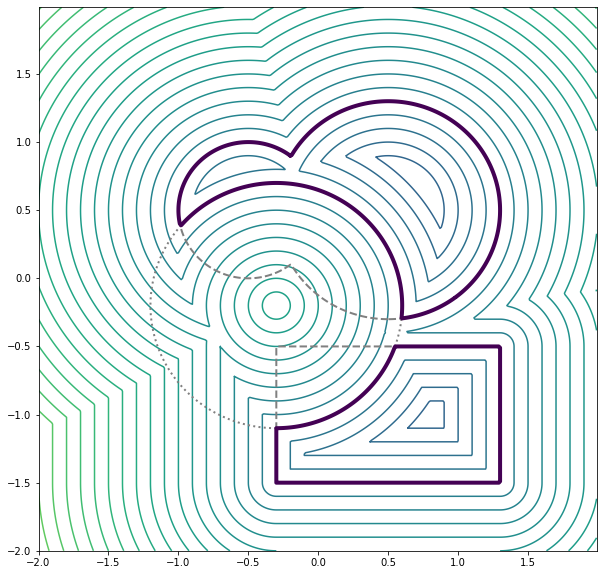

In [10]:
def difference(s1, s2):
    return lambda x,y : np.maximum(s1(x, y), -s2(x,y))

c6 = circle(-0.3, -0.2, 0.9)
diff = difference(u2, c6)

fig = plt.figure(figsize=(10,10))
plt.contour(x,y,diff(x,y), np.arange(-2,3,0.1))
plt.contour(x,y,u2(x,y), [0], colors = 'gray', linestyles = 'dashed', linewidths = 2)
plt.contour(x,y,c6(x,y), [0], colors = 'gray', linestyles = 'dotted', linewidths = 2)
plt.contour(x,y,diff(x,y), [0], linewidths = 4)

plt.show()

In [11]:
inter_update = animate_sphere_trace(diff, -1.5, -0.35, -0.1)
    
_=widgets.interact(inter_update, theta = (-math.pi/2, math.pi/2, 0.01))

interactive(children=(FloatSlider(value=-0.1, description='theta', max=1.5707963267948966, min=-1.570796326794…

With these basic operations and many more thricks, complex scenes can be modelled from simple primitives. Describing objects using these operations is a well established technique called *Constructive Solid Geometry* (CSG). Its use is not limited to signed distance functions, and many computer assisted design software describe their objects using this formalism.

### Splines

Splines are methods to describe shapes as multiple parametric patches. Historically, a spline is a thin piece of wood that was used in technical design to draw constrained curves. Each end of the spline was constrained in position and direction, letting the rest of the spline freely find its path. Mathematically, a spline is a piecewise polynomial curve. Each portion of the curve is given by a polynomial equation, and depending on the degree of the polynomials used, contraints can be set at the connection between the polynomials to ensure some degree of continuity.

There exists several basis to describe splines, depending on the way their shape is controlled. Seminal work on the subject should be shared between Pierre Bézier and Paul de Fajet de Casteljau, but Bézier worked for Renault and was allowed to publish his results while de Casterljau worked for Citroën and his work was kept secret. Bézier curves define splines using control points and Bernstein polynomials.

Bernstein polynomials of degree $d$ form a basis of the vector space of polynomials of degree at most $d$. Any polynomial of degree at most $d$ can therefore be decomposed as a weighted sum of Bernstein polynomials. Bézier curves define their control points as the weights of the Bernstein polynomials. In practical applications, degree three polynomials are used, since they allow for $\mathcal{C}^2$ connections between polynomial pieces, which is usually sufficient for engineering purposes. The degree 3 Bernstein polynomials are :

$$
\begin{aligned}
    B_0(x) &= (1-x)^3 \\
    B_1(x) &= 3x(1-x)^2 \\
    B_2(x) &= 3x^2(1-x) \\
    B_3(x) &= x^3
\end{aligned}
$$

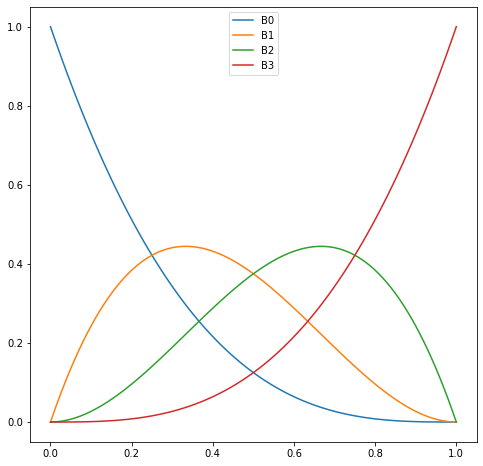

In [12]:
def B0(t):
    return (1-t)**3

def B1(t):
    return 3*t*((1-t)**2)

def B2(t):
    return 3*(t**2)*(1-t)

def B3(t):
    return t**3

B = [B0, B1, B2, B3]

t = np.linspace(0,1,100)

plt.figure(figsize = (8,8))
plt.plot(t, B0(t), label = 'B0')
plt.plot(t, B1(t), label = 'B1')
plt.plot(t, B2(t), label = 'B2')
plt.plot(t, B3(t), label = 'B3')
plt.legend(loc = 'upper center')
plt.show()

In [13]:
def bezier(p0, p1, p2, p3):
    return lambda t : p0 * B0(t) + p1 * B1(t) + p2 * B2(t) + p3 * B3(t)

def bezier_update(cx = 0.2):
    p = np.array([
        [0,0],
        [cx, 1],
        [0.8, -1],
        [1,0]
    ])

    bx = bezier(*p[:,0])
    by = bezier(*p[:,1])

    plt.figure(figsize = (8,8))
    plt.plot(bx(t), by(t))
    plt.plot(p[:2,0], p[:2,1], '-o')
    plt.plot(p[2:,0], p[2:,1], '-o')
    plt.show()
    
_ = widgets.interact(bezier_update, cx = (0,1,0.1))

interactive(children=(FloatSlider(value=0.2, description='cx', max=1.0), Output()), _dom_classes=('widget-inte…

With such control points, it becomes easy to control the position and normal at both ends of the curve. These curves are available in any vector graphics software as a basic primitive. The De Casteljau algorithm was meant to efficiently evaluate such curve at any point and render it. It is based on *polar forms* also called *blossoms* in this context. Any polynomial $p$ of degree $d$ can be associated with a *unique* polynomial $P$ of degree 1 in $d$ variables with the following properties :

* $P$ is multiaffine (affine in each of its variables) : if $a + b = 1$ then $p(\ldots,at_1 + bt_2,\ldots) = aP(\ldots, t_1, \ldots) + bP(\ldots, t_2, \ldots)$
* $P$ is symmetric (its variables can be swapped): $P(\ldots, t_1, \ldots, t_2, \ldots) = P(\ldots, t_2, \ldots, t_1, \ldots)$
* $P$ matches $p$ on the diagonal : $P(t, t, \ldots, t) = p(t)$

A Bézier piece $b$ as the one above is a degree 3 polynomial on a parameter $t \in [0,1]$, and therefore has a polar form $B$ of 3 variables. The four control points of the Bézier curve correspond to the values of $B(0,0,0) = b(0)$, $B(1,0,0)$, $B(1,1,0)$ and $B(1,1,1) = b(1)$. Computing the value of $b(t)$ for any $t$ is the same as computing $B(t,t,t)$, which can be done from the control points using symmetry and multiaffinity :

$$
\begin{aligned}
    B(t,0,0) &= (1-t)B(0,0,0) + tB(1,0,0) \\
    B(t,1,0) &= B(1,t,0) = (1-t)B(1,0,0) + tB(1,1,0) \\
    B(t,1,1) &= B(1,1,t) = (1-t)B(1,1,0) + tB(1,1,1) \\
    B(t,t,0) &= (1-t)B(t,0,0) + tB(t,1,0) \\
    B(t,t,1) &= (1-t)B(t,1,0) + tB(t,1,1) \\
    B(t,t,t) &= (1-t)B(t,t,0) + tB(t,t,1) \\
\end{aligned}
$$

Expressing $B(t,t,t)$ in terms of $B(0,0,0)$, $B(1,0,0)$, $B(1,1,0)$, $B(1,1,1)$, we obtain the Bernstein polynomials as expected. The interesting part lies in the intermediate points we obtain : $B(0,0,0)$, $B(t,0,0)$, $B(t,t,0)$ and $B(t,t,t)$ are the four control points of the piece of Bézier patch for the interval $[0,t]$. The other four points $B(t,t,t)$, $B(t,t,1) = B(1,t,t)$, $B(t,1,1) = B(1,1,t)$ and $B(1,1,1)$ are the control points of the Bézier patch for the interval $[t,1]$. We can therefore insert a new control point in the middle of the patch, and get the new set of control points to control both sides of the inserted point

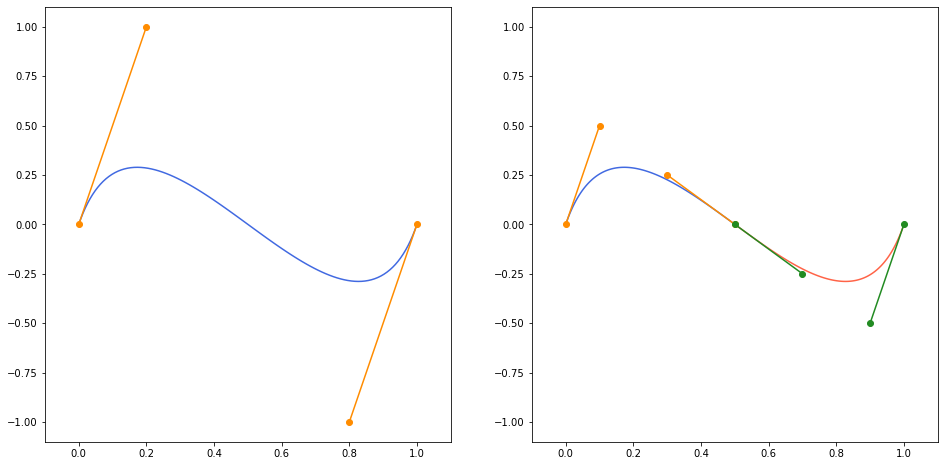

In [14]:
def bezier_split(p000, p100, p110, p111, t):
    pt00 = (1-t) * p000 + t * p100
    pt10 = (1-t) * p100 + t * p110
    pt11 = (1-t) * p110 + t * p111
    ptt0 = (1-t) * pt00 + t * pt10
    ptt1 = (1-t) * pt10 + t * pt11
    pttt = (1-t) * ptt0 + t * ptt1
    return np.array([p000, pt00, ptt0, pttt]), np.array([pttt, ptt1, pt11, p111])

p = np.array([
    [0,0],
    [0.2, 1],
    [0.8, -1],
    [1,0]
])

fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(121)
ax1.set_xlim((-0.1,1.1))
ax1.set_ylim((-1.1,1.1))


bx = bezier(*p[:,0])
by = bezier(*p[:,1])

ax1.plot(bx(t), by(t), color = 'royalblue')
ax1.plot(p[:2,0], p[:2,1], '-o', color = 'darkorange')
ax1.plot(p[2:,0], p[2:,1], '-o', color = 'darkorange')

ax2 = fig.add_subplot(122)
ax2.set_xlim((-0.1,1.1))
ax2.set_ylim((-1.1,1.1))

p1,p2 = bezier_split(*p, 0.5)
b1x = bezier(*p1[:,0])
b1y = bezier(*p1[:,1])
b2x = bezier(*p2[:,0])
b2y = bezier(*p2[:,1])

ax2.plot(b1x(t), b1y(t), color = 'royalblue')
ax2.plot(p1[:2,0], p1[:2,1], '-o', color = 'darkorange')
ax2.plot(p1[2:,0], p1[2:,1], '-o', color = 'darkorange')
ax2.plot(b2x(t), b2y(t), color = 'tomato')
ax2.plot(p2[:2,0], p2[:2,1], '-o', color = 'forestgreen')
ax2.plot(p2[2:,0], p2[2:,1], '-o', color = 'forestgreen')

plt.show()

This splitting technique is the core of the De Casteljau algorithm to accurately draw Bézier curves : recursively subdivide the pathches and sets of control points until all the control points for a patch end in a unique pixel, or fall below some resolution threshold.

This approach to define curved parametric patches generalizes to 3D using tensor product. A 2D bicubic Bézier patch uses 16 control points, $p_{0,0}, p_{1,0}, \ldots, p_{3,3}$, and the equation of the patch is given by

$$
\left\{ \sum_{i=0}^3\sum_{j=0}^3B_i(u)B_j(v)p_{i,j}, (u,v) \in [0,1]^2 \right\}
$$

In [15]:
u,v = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))

px,py = np.meshgrid(np.linspace(0,1,4), np.linspace(0,1,4))
pz = np.random.random((4,4))*2 - 1

bx = np.sum(np.array([[B[i](u)*B[j](v)*px[i,j] for j in range(4)] for i in range(4)]), axis = (0,1))
by = np.sum(np.array([[B[i](u)*B[j](v)*py[i,j] for j in range(4)] for i in range(4)]), axis = (0,1))
bz = np.sum(np.array([[B[i](u)*B[j](v)*pz[i,j] for j in range(4)] for i in range(4)]), axis = (0,1))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(bx,by,bz, color = 'royalblue')
ax.plot_wireframe(px, py, pz, color = 'tomato')
ax.scatter(px, py, pz, color = 'tomato')

def turntable(fig, angle_step):  
    plt.close()
    
    def animate(i):
        fig.gca().view_init(30, (angle_step *i) % 360)
        fig.canvas.draw_idle()
    
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=int(360 / angle_step), interval = 200);
    return (HTML(ani.to_html5_video()))

turntable(fig, 10)

Bézier surfaces are among the main primitives in computer assisted design softwares because the provide sufficient degrees of freedom for designing surfaces, while being able to describe complicated objects as a set of patches connected with $C^1$ continuity. Rendering such surfaces can be done by recursively subdividing patches in 4 smaller patches as was done in 2D, or converting them as triangle meshes which are described later in this document.